In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import random
import sys
import os
import matplotlib.pyplot as plt
import math
import scipy
from distcorr import distcorr
from fractions import gcd
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [50]:
NAN = 0

def fill_nan(array, REPLACE_COUNT):
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [3]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

In [4]:
# ENABLE/DISABLE GPU
# UNCOMMENT to.device() FOR TENSORS AND NEURAL NETWORKS TO ENABLE GPU

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
np.set_printoptions(threshold=sys.maxsize, precision=2, suppress=True)

In [103]:
dataset = pd.read_csv('breast/breast.csv')
dataset

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [104]:
# NARROW THE FEATURES
array = np.array(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst'])
processed_data = dataset[array]
processed_data

,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst
0,17.99,122.80,1001.0,25.380,184.60,2019.0
1,20.57,132.90,1326.0,24.990,158.80,1956.0
2,19.69,130.00,1203.0,23.570,152.50,1709.0
3,11.42,77.58,386.1,14.910,98.87,567.7
4,20.29,135.10,1297.0,22.540,152.20,1575.0
...,...,...,...,...,...,...
564,21.56,142.00,1479.0,25.450,166.10,2027.0
565,20.13,131.20,1261.0,23.690,155.00,1731.0
566,16.60,108.30,858.1,18.980,126.70,1124.0
567,20.60,140.10,1265.0,25.740,184.60,1821.0


In [105]:
# for i in range(len(processed_data.columns)):
#     for j in range(i+1, len(processed_data.columns)):
#         corr, _ = pearsonr(processed_data[processed_data.columns[i]], processed_data[processed_data.columns[j]])
#         print("PEARSONR: ", processed_data.columns[i], processed_data.columns[j], corr)
#         print("DCORR: ", processed_data.columns[i], processed_data.columns[j], distcorr(processed_data[processed_data.columns[j]], processed_data[processed_data.columns[i]]))

In [106]:
# for i in range(len(processed_data.columns)):
#     for j in range(i+1, len(processed_data.columns)):
#         processed_data.plot(x=processed_data.columns[i], y=processed_data.columns[j], style='o')

In [107]:
# CONVERT TO NUMPY
numpy_data = processed_data.to_numpy()
numpy_data[0]

array([  17.99,  122.8 , 1001.  ,   25.38,  184.6 , 2019.  ])

In [108]:
# NORMALIZE THE DATA
scaled_data = scaler.fit_transform(numpy_data)

In [109]:
full_data = scaled_data.copy()
missing_data = fill_nan(scaled_data, scaled_data.size*0.2)

In [113]:
bins = np.linspace(0, 10)
y_binned = np.digitize(full_data[:,0], bins)
y_binned

array([3, 4, 3, 2, 4, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 1,
       2, 4, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 3, 2,
       2, 3, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 1, 1, 2, 1, 2, 2,
       1, 2, 1, 2, 3, 1, 3, 2, 2, 3, 2, 3, 4, 2, 2, 2, 5, 3, 2, 3, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 4, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 3, 3, 2, 3, 5, 2, 2, 2, 2, 3, 2, 3, 2, 2,
       3, 3, 3, 2, 2, 2, 2, 1, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 3, 3, 2, 1, 2, 3, 3, 2, 4, 2, 1, 3, 3, 2, 2, 2, 2, 1, 1, 1,
       1, 3, 2, 2, 5, 4, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3,
       3, 2, 2, 3, 4, 2, 2, 2, 1, 3, 2, 2, 4, 2, 5, 3, 2, 2, 2, 1, 3, 3,
       2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 3, 2, 1, 4, 1, 2, 4, 4, 2, 3, 2, 2,
       2, 2, 3, 1, 2, 2, 1, 2, 4, 2, 3, 3, 3, 2, 3, 2, 3, 2, 4, 3, 3, 3,
       3, 4, 1, 2, 2, 1, 2, 1, 4, 1, 3, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3,

In [114]:
x_train, x_test, y_train, y_test = train_test_split(missing_data, full_data, stratify=y_binned, random_state=0)

In [115]:
x_train

[0.    , 0.    , 0.1539, 0.    , 0.    , 0.1151],
       [0.3024, 0.2924, 0.1739, 0.2252, 0.    , 0.1098],
       [0.5949, 0.6206, 0.    , 0.    , 0.6384, 0.    ],
       [0.2077, 0.1961, 0.1071, 0.    , 0.1438, 0.0674],
       [0.    , 0.2915, 0.1659, 0.2753, 0.2609, 0.1411],
       [0.1552, 0.1518, 0.0755, 0.1227, 0.1137, 0.0514],
       [0.1637, 0.    , 0.    , 0.1277, 0.    , 0.0517],
       [0.8353, 0.8411, 0.    , 0.7823, 0.7734, 0.6038],
       [0.3843, 0.    , 0.2415, 0.3618, 0.3351, 0.2076],
       [0.3521, 0.348 , 0.2111, 0.3109, 0.3038, 0.    ],
       [0.2792, 0.281 , 0.1483, 0.2533, 0.2435, 0.1203],
       [0.1296, 0.1171, 0.0613, 0.0725, 0.    , 0.0291],
       [0.5144, 0.4893, 0.36  , 0.423 , 0.    , 0.2519],
       [0.3658, 0.    , 0.2178, 0.3536, 0.3252, 0.1967],
       [0.1661, 0.1632, 0.0817, 0.    , 0.1186, 0.    ],
       [0.    , 0.2651, 0.1429, 0.1921, 0.1922, 0.0841],
       [0.2257, 0.2233, 0.1172, 0.1917, 0.1917, 0.0882],
       [0.    , 0.3369, 0.    , 0.2782

In [116]:
y_train

[0.274 , 0.2621, 0.1539, 0.2334, 0.2073, 0.1151],
       [0.3024, 0.2924, 0.1739, 0.2252, 0.2071, 0.1098],
       [0.5949, 0.6206, 0.4511, 0.609 , 0.6384, 0.4278],
       [0.2077, 0.1961, 0.1071, 0.1576, 0.1438, 0.0674],
       [0.2929, 0.2915, 0.1659, 0.2753, 0.2609, 0.1411],
       [0.1552, 0.1518, 0.0755, 0.1227, 0.1137, 0.0514],
       [0.1637, 0.1578, 0.0789, 0.1277, 0.1148, 0.0517],
       [0.8353, 0.8411, 0.72  , 0.7823, 0.7734, 0.6038],
       [0.3843, 0.3695, 0.2415, 0.3618, 0.3351, 0.2076],
       [0.3521, 0.348 , 0.2111, 0.3109, 0.3038, 0.1664],
       [0.2792, 0.281 , 0.1483, 0.2533, 0.2435, 0.1203],
       [0.1296, 0.1171, 0.0613, 0.0725, 0.059 , 0.0291],
       [0.5144, 0.4893, 0.36  , 0.423 , 0.3819, 0.2519],
       [0.3658, 0.3577, 0.2178, 0.3536, 0.3252, 0.1967],
       [0.1661, 0.1632, 0.0817, 0.1284, 0.1186, 0.0535],
       [0.2674, 0.2651, 0.1429, 0.1921, 0.1922, 0.0841],
       [0.2257, 0.2233, 0.1172, 0.1917, 0.1917, 0.0882],
       [0.3426, 0.3369, 0.2038, 0.2782

In [117]:
# # SPLIT INTO TRAIN/TEST SETS (0.8 / 0.2)
# trainset = scaled_data[:455, :]
# testset = scaled_data[455:, :]
# trainset

In [118]:
# full_data_train = trainset.copy()

# missing_data_train = fill_nan(trainset, trainset.size*0.2)

# full_data_test = testset.copy()

# missing_data_test = fill_nan(testset, testset.size*0.2) 

In [119]:
# missing_data_train[1]

In [120]:
# full_data_train[1]

In [124]:
x_train = torch.from_numpy(x_train)
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(y_train)
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(x_test)
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(y_test)
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([426, 6])

In [180]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=6, out_features=8)
        self.enc2 = nn.Linear(in_features=8, out_features=16)
        # self.enc3 = nn.Linear(in_features=3, out_features=2)

        # self.dec1 = nn.Linear(in_features=2, out_features=3)
        self.dec2 = nn.Linear(in_features=16, out_features=8)
        self.dec3 = nn.Linear(in_features=8, out_features=6)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        # x = F.leaky_relu(self.enc3(x))
        # x = F.leaky_relu(self.dec1(x))
        x = F.leaky_relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [181]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [183]:
NUM_EPOCHS = 110
LEARNING_RATE = 0.0001
BATCH_SIZE = -1
NUM_FEATURES = 6
BATCH_SIZE_TEST = -1

In [184]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [185]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=True)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                    print("Target: ", scaler.inverse_transform(full_data.reshape(-1,6)))
                    print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
                else:
                    print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                    print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,6)))
                    print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        train_loss.append(loss)

        print('Epoch {} of {}, Train Loss: {:.5f}, Overall: {:.5f}'
             .format(epoch+1, NUM_EPOCHS, loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                print("Target: ", scaler.inverse_transform(full_data.reshape(-1,6)))
                print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
            else:
                print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,6)))
                print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))

        loss = running_loss / count
        test_loss.append(loss)
        print('Test Loss: {:.3f}'.format(loss))

        return test_loss

In [186]:
# TRAIN THE NEURAL NETWORK
results = train(net)

[[  23.68  158.33 1623.18   29.37  200.75 2413.81]]
Input (missing):  [[ 12.    76.77 442.5   13.09  50.41 523.7 ]]
Target (missing):  [[ 12.    76.77 442.5   13.09  85.07 523.7 ]]
Outputs (missing):  [[ 12.14  78.23 452.78  13.55  87.62 567.99]]
Input (missing):  [[ 14.4   43.79 646.1   15.4  100.4  734.6 ]]
Target (missing):  [[ 14.4   92.25 646.1   15.4  100.4  734.6 ]]
Outputs (missing):  [[ 13.89  89.24 595.54  15.61 102.63 823.76]]
Input (missing):  [[  6.98  43.79 462.    13.13  87.65 529.9 ]]
Target (missing):  [[ 12.21  78.78 462.    13.13  87.65 529.9 ]]
Outputs (missing):  [[ 11.58  74.17 393.14  12.64  83.04 466.09]]
Input (missing):  [[  6.98  43.79 363.7   11.37  72.42 185.2 ]]
Target (missing):  [[ 10.91  69.14 363.7   11.37  72.42 392.2 ]]
Outputs (missing):  [[ 10.24  66.72 317.1   11.45  72.92 302.08]]
Input:  [[ 13.61  87.76 572.6   16.89 113.2  848.7 ]]
Target:  [[ 13.61  87.76 572.6   16.89 113.2  848.7 ]]
Outputs:  [[ 14.68  95.14 690.6   16.78 111.87 955.32]]
Inp

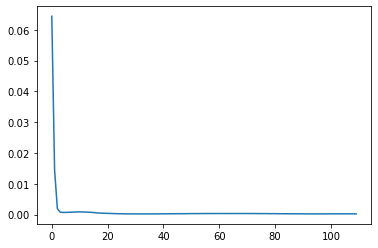

In [187]:
plt.plot(results)

In [188]:
# TEST THE NEURAL NETWORK
test_result = test(net)

9.83 454.08  13.71  89.83 598.24]]
Input (missing):  [[  6.98  73.93 389.4   12.58  87.16 185.2 ]]
Target (missing):  [[ 11.3   73.93 389.4   12.58  87.16 472.9 ]]
Outputs (missing):  [[ 11.85  75.72 414.01  12.97  85.43 503.8 ]]
Input (missing): [[  6.98  81.92 143.5   13.37  89.02 547.4 ]]
Target (missing):  [[ 12.56  81.92 485.8   13.37  89.02 547.4 ]]
Outputs (missing):  [[ 12.09  77.64 444.37  13.38  87.94 548.39]]
Input (missing):  [[ 14.48  94.25 143.5   16.21 108.4  808.9 ]]
Target (missing):  [[ 14.48  94.25 648.2   16.21 108.4  808.9 ]]
Outputs (missing):  [[ 14.34  93.01 661.29  16.48 108.41 910.95]]
Input (missing):  [[ 11.32  43.79 395.7   12.08  79.82 452.3 ]]
Target (missing):  [[ 11.32  71.76 395.7   12.08  79.82 452.3 ]]
Outputs (missing):  [[ 11.69  75.04 403.35  12.89  83.54 488.29]]
Input (missing):  [[ 15.61  43.79 758.6   17.91  50.41 988.6 ]]
Target (missing):  [[ 15.61 100.   758.6   17.91 115.9  988.6 ]]
Outputs (missing):  [[  14.96   98.92  758.7    17.88  11

In [189]:
torch.save(net, './breast_autoencoder_stratify')

# The following section is for reconstructing a brand new dataset from an input dataset that has missing values.
# This new dataset can be used in some classifiers to see if the accuracy changes.

In [219]:
dataset = pd.read_csv('breast/breast.csv')
array = np.array(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst'])
filtered_data = dataset[array]
filtered_data

,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst
0,17.99,122.80,1001.0,25.380,184.60,2019.0
1,20.57,132.90,1326.0,24.990,158.80,1956.0
2,19.69,130.00,1203.0,23.570,152.50,1709.0
3,11.42,77.58,386.1,14.910,98.87,567.7
4,20.29,135.10,1297.0,22.540,152.20,1575.0
...,...,...,...,...,...,...
564,21.56,142.00,1479.0,25.450,166.10,2027.0
565,20.13,131.20,1261.0,23.690,155.00,1731.0
566,16.60,108.30,858.1,18.980,126.70,1124.0
567,20.60,140.10,1265.0,25.740,184.60,1821.0


In [220]:
np.set_printoptions(precision=4, suppress=True)
scaled_set = scaler.fit_transform(filtered_data.to_numpy())
scaled_set

[0.6067, 0.5937, 0.4609, 0.6332, 0.5971, 0.4482],
       [0.5939, 0.5819, 0.4579, 0.7104, 0.6464, 0.5633],
       [0.3156, 0.3047, 0.1804, 0.2636, 0.2455, 0.128 ],
       [0.3114, 0.3096, 0.1772, 0.2508, 0.2525, 0.1232],
       [0.1514, 0.1474, 0.0719, 0.1153, 0.1072, 0.0468],
       [0.415 , 0.4064, 0.2621, 0.4137, 0.376 , 0.2219],
       [0.2976, 0.2817, 0.1709, 0.2565, 0.2412, 0.1287],
       [0.3483, 0.3367, 0.2111, 0.3145, 0.2988, 0.1691],
       [0.1637, 0.1578, 0.0789, 0.1277, 0.1148, 0.0517],
       [0.3795, 0.3708, 0.2295, 0.3017, 0.3177, 0.1531],
       [0.2669, 0.2596, 0.1497, 0.2231, 0.2005, 0.1078],
       [0.2768, 0.2866, 0.1526, 0.2586, 0.2734, 0.128 ],
       [0.4765, 0.481 , 0.3188, 0.4148, 0.4138, 0.2467],
       [0.2054, 0.1933, 0.107 , 0.1476, 0.1465, 0.0656],
       [0.2006, 0.1866, 0.1032, 0.1576, 0.1396, 0.0702],
       [0.6403, 0.6261, 0.4986, 0.5884, 0.5592, 0.4146],
       [0.1224, 0.1135, 0.0577, 0.0918, 0.0763, 0.037 ],
       [0.3336, 0.3179, 0.1951, 0.2633

In [221]:
missing_data = fill_nan(scaled_set, scaled_set.size*0.2)

input_tensor = torch.from_numpy(missing_data)
input_tensor = input_tensor.view(input_tensor.shape[0], NUM_FEATURES)

In [222]:
input_tensor

tensor([[0.5210, 0.5460, 0.3637, 0.6208, 0.0000, 0.4507],
        [0.6431, 0.6158, 0.0000, 0.6069, 0.5398, 0.4352],
        [0.6015, 0.5957, 0.4494, 0.5564, 0.5084, 0.0000],
        ...,
        [0.0000, 0.4458, 0.3031, 0.3931, 0.0000, 0.2307],
        [0.6446, 0.6655, 0.0000, 0.6336, 0.6683, 0.4020],
        [0.0369, 0.0285, 0.0000, 0.0543, 0.0436, 0.0205]], dtype=torch.float64)

In [231]:
my_model = torch.load('breast_autoencoder_stratify')
my_model

Autoencoder(
  (enc1): Linear(in_features=6, out_features=8, bias=True)
  (enc2): Linear(in_features=8, out_features=16, bias=True)
  (dec2): Linear(in_features=16, out_features=8, bias=True)
  (dec3): Linear(in_features=8, out_features=6, bias=True)
)

In [232]:
new_dataset = my_model(input_tensor.double())
torch.set_printoptions(precision=4, sci_mode=False)
new_dataset

tensor([[0.5916, 0.6173, 0.4887, 0.6068, 0.5616, 0.4061],
        [0.6261, 0.6331, 0.4923, 0.6159, 0.5811, 0.4230],
        [0.6031, 0.5955, 0.4494, 0.5664, 0.5503, 0.3907],
        ...,
        [0.3424, 0.3525, 0.2422, 0.3191, 0.3067, 0.1814],
        [0.6400, 0.6422, 0.4967, 0.6208, 0.5929, 0.4294],
        [0.1200, 0.1316, 0.0565, 0.1040, 0.0851, 0.0069]], dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [233]:
new_dataset = scaler.inverse_transform(new_dataset.detach().numpy())
new_dataset

378,  836.5537,   19.1106,  119.5475, 1187.087 ],
       [  11.2658,   72.5607,  377.7111,   12.4476,   80.6696,  430.3955],
       [  12.1088,   77.2859,  429.4769,   13.2706,   86.9253,  541.1547],
       [  12.3826,   78.9878,  448.705 ,   13.5664,   89.1095,  577.8266],
       [  13.468 ,   86.0799,  559.9214,   15.0828,   99.427 ,  762.6899],
       [   9.3932,   62.264 ,  269.3851,   10.7861,   66.1774,  201.1617],
       [  11.9611,   76.4265,  421.3651,   13.1354,   85.8871,  523.2245],
       [  12.3136,   78.4347,  451.5173,   13.5858,   88.6246,  582.8568],
       [  12.4126,   79.2256,  452.2175,   13.615 ,   89.4175,  582.9988],
       [  14.9187,   96.9066,  711.5153,   17.1438,  114.1883,  988.7883],
       [  12.6826,   82.1698,  505.0637,   14.4014,   92.1653,  658.848 ],
       [  10.7874,   69.833 ,  351.272 ,   12.0058,   77.2761,  371.5261],
       [   9.4843,   62.6724,  274.2465,   10.824 ,   67.1994,  208.8238],
       [  12.823 ,   81.6452,  493.8948,   14.1839

In [234]:
np.savetxt('new_breast.csv', new_dataset)